## Download kaggle data in Google Colab

In [6]:
# Peso (7.19 GB)
!kaggle datasets download -d anirudhcv/labeled-optical-coherence-tomography-oct

Dataset URL: https://www.kaggle.com/datasets/anirudhcv/labeled-optical-coherence-tomography-oct
License(s): unknown
100% 6.69G/6.70G [01:33<00:00, 99.2MB/s]
100% 6.70G/6.70G [01:33<00:00, 77.2MB/s]


In [7]:
!unzip -q /content/labeled-optical-coherence-tomography-oct.zip -d /content
!rm /content/labeled-optical-coherence-tomography-oct.zip

## Clonar carpeta de drive con modelos entrenados


In [1]:
!pip install gdown
!gdown --folder https://drive.google.com/drive/folders/1oROCe2k7RTvufSccOM2L1a7xVIvQqh_X?usp=sharing


Retrieving folder contents
Processing file 1fwZc9qJtLZoe5vsfvNw9COlmhZtz0bkK convnext_best_model.pth
Processing file 1i91gSL8FQTKx4PpWudXA8KA2Y0UYgBZQ convnext_best_model2.pth
Processing file 1H_UVm0tnHThX8sCW9ID9FMhNcV5XfWld convnext_best_model3.pth
Processing file 13dwou3DJtD6uvzFnqEOetQgpqIgi5Co9 resnet_best_model.pth
Processing file 1LNsgStdcuhQcuBY1eGHQCzkG8QckmAiQ resnet_best_model2.pth
Processing file 1hre-KjaOhBOungheU1Ysi6LLrrofjyiT resnet_best_model3.pth
Processing file 1qs5gUy4X20WgPzU_igRDYFcvMSNNhB0K swin_transformer_best_model.pth
Processing file 1bcF4IiaXapGL4Qxigq-H_GQb_rq89agr swin_transformer_best_model2.pth
Processing file 1nZXI1Ef8ACEsI4mwpcCCyvmZA66yIJ8Y swin_transformer_best_model3.pth
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1fwZc9qJtLZoe5vsfvNw9COlmhZtz0bkK
From (redirected): https://drive.google.com/uc?id=1fwZc9qJtLZoe5vsfvNw9COlmhZtz0b

## Import libraries

In [2]:
import os
import random
import matplotlib.image as mpimg
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from skimage import exposure
from skimage.io import imread
import cv2
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import timm
import time
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,balanced_accuracy_score
import seaborn as sns

## Funciones


### Filtros


In [3]:
def apply_canny(image):
    """Apply Canny edge detection to an image."""
    return cv2.Canny(image, 100, 200)

def apply_equalization(image):
    """Apply histogram equalization to an image."""
    if len(image.shape) == 2:  # Grayscale image
        return cv2.equalizeHist(image)
    elif len(image.shape) == 3:  # Color image, apply to each channel
        channels = cv2.split(image)
        eq_channels = [cv2.equalizeHist(channel) for channel in channels]
        return cv2.merge(eq_channels)

def apply_sobel(image):
    """Apply Sobel filter to detect edges in an image."""
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    sobel_combined = cv2.magnitude(sobelx, sobely)
    return cv2.convertScaleAbs(sobel_combined)


# Función para crear los datasets con filtros aplicados
def create_filtered_datasets(input_dir, output_base_dir):
    """Crea los datasets con los filtros aplicados a las imágenes."""

    filters = {
        # 'original': lambda img: img,
        # 'canny': apply_canny,
        'equalized': apply_equalization,
        #'sobel': apply_sobel
    }

    # Comprobar que el directorio de entrada existe
    if not os.path.exists(input_dir):
        print(f"Error: El directorio de entrada '{input_dir}' no existe.")
        return

    # Crear el directorio base de salida
    if not os.path.exists(output_base_dir):
        os.makedirs(output_base_dir, exist_ok=True)
        print(f"Directorio de salida '{output_base_dir}' creado.")

    # Iterar sobre los filtros
    for filter_name, filter_func in filters.items():
        print(f"Procesando el filtro: {filter_name}")

        # Iterar sobre las carpetas principales: train, test, val
        for subset in ['train', 'test', 'val']:
            subset_input_dir = os.path.join(input_dir, subset)
            if not os.path.exists(subset_input_dir):
                print(f"Advertencia: No se encontró el directorio '{subset_input_dir}'.")
                continue  # Si no existe la carpeta 'train', 'test' o 'val', saltar

            # Crear el directorio para este filtro en cada subset (train, test, val)
            subset_output_dir = os.path.join(output_base_dir, subset, filter_name)
            os.makedirs(subset_output_dir, exist_ok=True)

            # Iterar sobre las carpetas de clase (por ejemplo, CNV, DME, Normal)
            for class_folder in os.listdir(subset_input_dir):
                class_path = os.path.join(subset_input_dir, class_folder)

                if not os.path.isdir(class_path):
                    continue  # Saltar si no es una carpeta

                print(f"Procesando la clase: {class_folder} en el subset: {subset}")

                # Crear el directorio de salida para esta clase
                class_output_dir = os.path.join(subset_output_dir, class_folder)
                os.makedirs(class_output_dir, exist_ok=True)

                # Iterar sobre las imágenes dentro de la carpeta de clase
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)

                    if not os.path.isfile(img_path) or not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        continue  # Saltar si no es una imagen válida

                    print(f"Procesando la imagen: {img_name}")

                    img = cv2.imread(img_path, cv2.IMREAD_COLOR)

                    # Verificar si la imagen se cargó correctamente
                    if img is None:
                        print(f"Error al cargar la imagen: {img_path}")
                        continue  # Saltar si no se puede cargar

                    # Si el filtro es 'canny', leer en escala de grises
                    if filter_name == 'canny':
                        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                    # Aplicar el filtro
                    processed_img = filter_func(img)

                    # Verificar si la imagen procesada está vacía
                    if processed_img is None or processed_img.size == 0:
                        print(f"Error al procesar la imagen: {img_path}")
                        continue  # Saltar si la imagen procesada es vacía

                    # Guardar la imagen procesada
                    output_img_path = os.path.join(class_output_dir, img_name)
                    if cv2.imwrite(output_img_path, processed_img):
                        print(f"Imagen guardada: {output_img_path}")
                    else:
                        print(f"Error al guardar la imagen: {output_img_path}")


### Pruebas y visualización de resultados

In [12]:
# Mostrar imágenes y sus predicciones
def visualize_predictions(model, dataloader, class_names, num_images=10, save_path="predictions.png"):
    model.eval()
    images_so_far = 0
    plt.figure(figsize=(20, 10))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                images_so_far += 1
                ax = plt.subplot(num_images // 5, 5, images_so_far)
                ax.axis('off')
                ax.set_title(f"Pred: {class_names[preds[j]]}\nLabel: {class_names[labels[j]]}")
                img = inputs[j].cpu().numpy().transpose((1, 2, 0))
                img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Desnormalizar
                img = np.clip(img, 0, 1)
                plt.imshow(img)

                if images_so_far == num_images:
                    # Guardar la imagen en lugar de mostrarla
                    plt.savefig(save_path)
                    plt.show()
                    return

# Función para evaluar el modelo y calcular las métricas
def evaluate_model(model, dataloader, dataset_size, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            running_corrects += torch.sum(preds == labels.data)

    # Calcular métricas
    accuracy = accuracy_score(all_labels, all_preds)
    balanced_accuracy = balanced_accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # Imprimir las métricas
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    # Calcular la matriz de confusión
    cm = confusion_matrix(all_labels, all_preds)

    return accuracy, balanced_accuracy, precision, recall, f1, cm, class_names

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, class_names, save_path="confusion_matrix.png"):
    # Normalizar la matriz de confusión
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Crear subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Matriz de confusión normal
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[0])
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Predicted Labels')
    axes[0].set_ylabel('True Labels')

    # Matriz de confusión normalizada
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[1])
    axes[1].set_title('Normalized Confusion Matrix')
    axes[1].set_xlabel('Predicted Labels')
    axes[1].set_ylabel('True Labels')

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()


def get_transforms(input_size):
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(input_size + 32),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(input_size + 32),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
    return data_transforms

# Definir la función para cargar el modelo
def load_model(model_path, model_name, num_classes=4):
    if model_name == 'resnet':
        model = models.resnet50(pretrained=False)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'inception_v3':
        model = models.inception_v3(pretrained=False)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        model.aux_logits = False
    elif model_name == 'convnext':
        model = timm.create_model('convnext_tiny', pretrained=False, num_classes=num_classes)
    elif model_name == 'swin_transformer':
        model = timm.create_model('swin_base_patch4_window7_224', pretrained=False, num_classes=num_classes)
    else:
        raise ValueError('Modelo no soportado')

    # Cargar solo los pesos
    try:
        checkpoint = torch.load(model_path, map_location=device)

        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            # Caso: El archivo es un checkpoint completo
            model.load_state_dict(checkpoint['model_state_dict'])
            print("Checkpoint cargado correctamente.")
        else:
            # Caso: El archivo contiene directamente los pesos
            model.load_state_dict(checkpoint)
            print("Pesos del modelo cargados correctamente.")
    except Exception as e:
        print(f"No se pudo cargar el modelo desde {model_path}. Error: {e}")
        return None  # O manejar el error según tu caso

    # Mover el modelo al dispositivo y cambiar a modo de evaluación
    model = model.to(device)
    model.eval()
    return model

# Pre-procesar los datos

In [ ]:
# Aplicar filtros para resaltar las anomalías en las imágenes
folder_path="Dataset - train+val+test"
output_base_dir="Dataset - train+val+test_filtered"
create_filtered_datasets(folder_path, output_base_dir)

## Cargar datos


In [8]:
# Detectar dispositivo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo en uso: {device}")

# Directorios de datos
# data_dir = '/content/Dataset - train+val+test_filtered/'
# train_dir = os.path.join(data_dir, 'train/equalized')
# val_dir = os.path.join(data_dir, 'val/equalized')
# test_dir = os.path.join(data_dir, 'test/equalized')
data_dir = 'Dataset - train+val+test/'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

Dispositivo en uso: cpu


# Prueba

In [14]:
# Configuraciones
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model_name = "resnet"
model_name = "swin_transformer"
model_path = f"Modelos_entrenados/{model_name}_best_model.pth"
input_size = 224  # Tamaño de entrada
batch_size = 32

In [15]:
# Transformaciones y conjunto de datos de prueba
data_transforms = get_transforms(input_size)
test_dataset = ImageFolder(test_dir, transform=data_transforms['test'])
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Cargar el modelo
model = load_model(model_path, model_name)

<ipython-input-12-b9a91177a9e5>:134: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Checkpoint cargado correctamente.


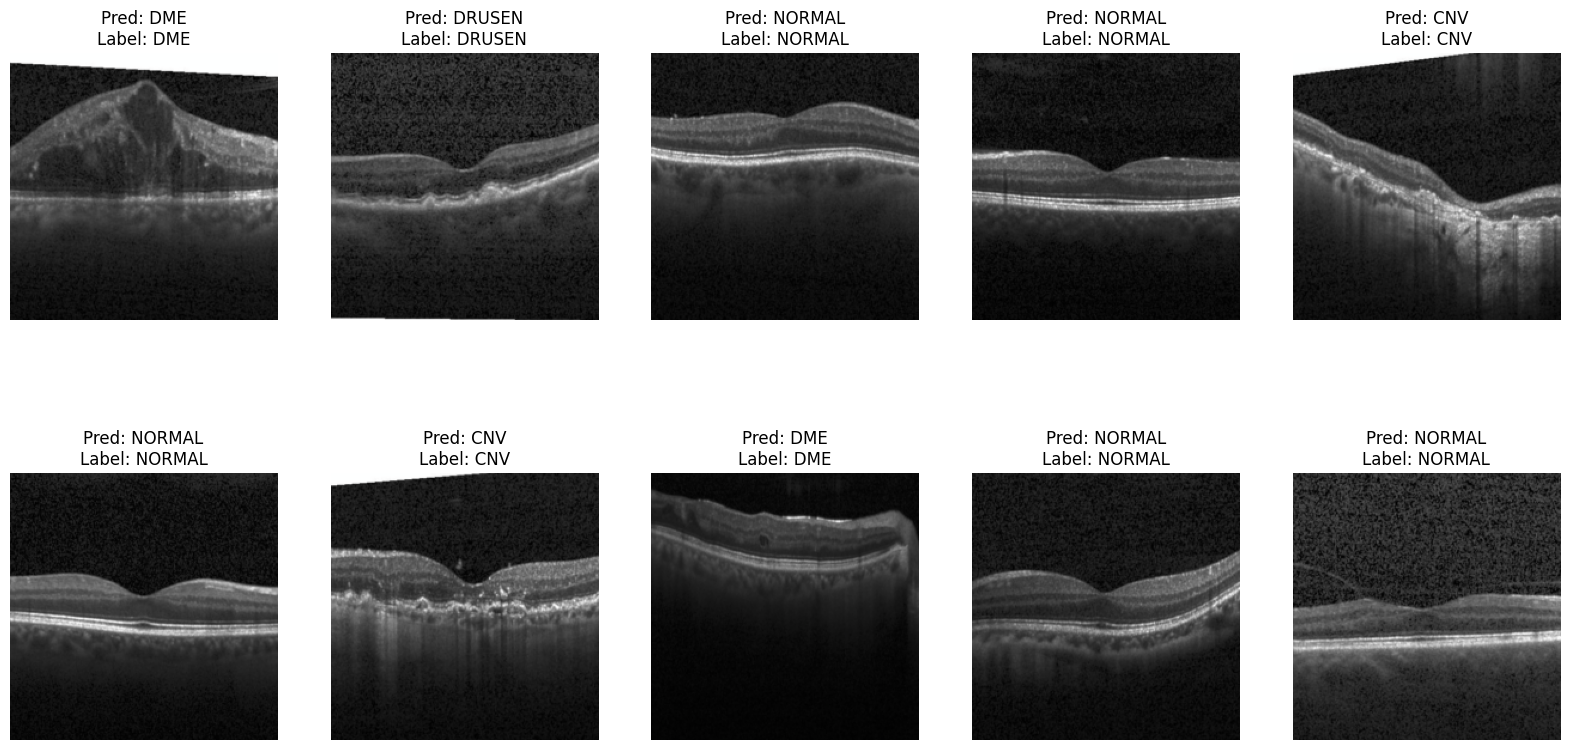

In [16]:
# Visualizar predicciones
visualize_predictions(model, test_dataloader, test_dataset.classes, num_images=10)

In [ ]:
# Evaluar el modelo
accuracy, precision, recall, f1, sensitivity,cm, class_names = evaluate_model(model, test_dataloader, len(test_dataset), test_dataset.classes)

In [ ]:
# Calcular la matriz de confusión
plot_confusion_matrix(cm, class_names)